In [6]:
# just run this cell once at top of notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import pandas_datareader.data as web
import utils

In [8]:
# from utils.data_scraper import download_sp500_tickers 
# sp500_list = download_sp500_tickers(save_local=True)
# print(sp500_list[:5])
# from utils.data_scraper import download_sp500_data

# download_sp500_data(sp500_list, save_local=True)

In [9]:
models = utils.models
data_scraper = utils.data_scraper

In [10]:
df = data_scraper.get_sp500_data()
df.dropna(inplace=True)
df = df[df.index.get_level_values('ticker') != 'SPY']
sp500_list = data_scraper.get_sp500_tickers()
sp500_list = [ticker for ticker in sp500_list if ticker != 'SPY']

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:131: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Loaded 504 tickers from local file.


In [11]:
df

adj_close       close        high         low        open  \
date       ticker                                                               
2010-01-04 A        19.891682   22.389128   22.625179   22.267525   22.453505   
           AAPL      6.418383    7.643214    7.660714    7.585000    7.622500   
           ABT      18.414783   26.129908   26.177889   25.870815   26.000362   
           ACGL      7.601905    7.994444    8.022222    7.972222    7.978889   
           ACN      31.492163   42.070000   42.200001   41.500000   41.520000   
...                       ...         ...         ...         ...         ...   
2025-10-31 XYZ      75.940002   75.940002   76.438004   74.440002   74.610001   
           YUM     137.558594  138.210007  138.460007  137.330002  138.419998   
           ZBH     100.559998  100.559998  101.870003   98.000000   98.650002   
           ZBRA    269.250000  269.250000  272.079987  261.489990  264.529999   
           ZTS     144.089996  144.089996  144.679993  142.309998  142.570007   

                        volume  
date       ticker               
2010-01-04 A         3815561.0  
           AAPL    493729600.0  
           ABT      10829095.0  
           ACGL      4813200.0  
           ACN       3650100.0  
...                        ...  
2025-10-31 XYZ       7364700.0  
           YUM       2422800.0  
           ZBH       2124800.0  
           ZBRA       659300.0  
           ZTS       3338200.0  

[1880825 rows x 6 columns]

In [12]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['high'] - np.log(df['low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['adj_close']) - np.log(df['open']) ** 2))
df['rsi'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: pandas_ta.rsi(x, length=20))
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['high'] - np.log(df['low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['adj_close']) - np.log(df['open']) ** 2))
df['rsi'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: pandas_ta.rsi(x, length=20))

df['bb_low'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

# bb_pct: percentage distance from the middle band (BBM)
# (adj_close - bb_mid) / bb_mid
df['bb_pct'] = (df['adj_close'] - df['bb_mid']) / df['bb_mid']

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='date'>

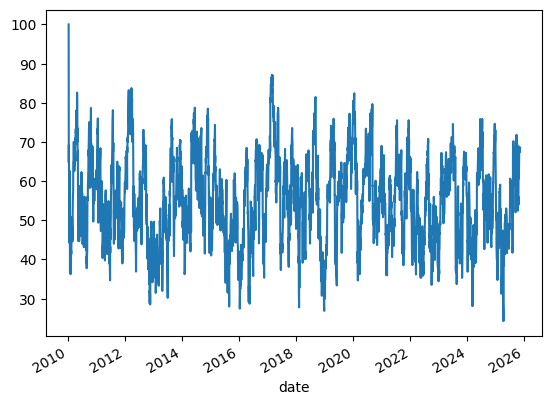

In [13]:
# All 'close' prices for ticker 'AAPL' across all dates
df.xs('AAPL', level='ticker')['rsi'].plot()

In [14]:
df.xs('A', level='ticker').head()

,adj_close,close,high,low,open,volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,bb_pct
date,,,,,,,,,,,,
2010-01-04,19.891682,22.389128,22.625179,22.267525,22.453505,3815561.0,3.866930,NaN,NaN,NaN,NaN,NaN
2010-01-05,19.675610,22.145924,22.331903,22.002861,22.324751,4186031.0,3.848832,0.0,NaN,NaN,NaN,NaN
2010-01-06,19.605701,22.067240,22.174536,22.002861,22.067240,3243779.0,3.816224,0.0,NaN,NaN,NaN,NaN
2010-01-07,19.580275,22.038628,22.045780,21.816881,22.017166,3095172.0,3.808263,0.0,NaN,NaN,NaN,NaN
2010-01-08,19.573912,22.031473,22.067240,21.745352,21.917025,3733918.0,3.799166,0.0,NaN,NaN,NaN,NaN


In [15]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj_close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [16]:
df = df.dropna()

In [17]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [18]:
df['macd'] = df.groupby(level='ticker', group_keys=False)['adj_close'].apply(compute_macd)

In [19]:
df['dollar_volume'] = (df['volume'] * df['adj_close'])/1e6
df['close_over_open'] = np.log(df['adj_close'] / df['open'])

In [20]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([df.unstack(level='ticker')['dollar_volume'].resample('ME').mean().stack(level='ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='ticker', future_stack=True)], axis=1).dropna()

In [21]:
data

dollar_volume   adj_close  garman_klass_volatility  \
date       ticker                                                       
2010-03-31 A          111.107494   21.855427                 4.119333   
           AAPL      3542.834285    7.047896                 1.682247   
           ABT        321.714677   17.943003                 4.264503   
           ACGL        24.905408    8.056224                 1.630745   
           ACN        117.879207   31.402344                 5.734963   
...                          ...         ...                      ...   
2025-10-31 KVUE       489.424636   14.191235                 2.702746   
           VLTO       147.617908   98.680000                 8.597113   
           SOLV        63.415672   69.040001                 7.260977   
           GEV       1913.529986  585.140015                16.336428   
           SNDK      1225.782463  199.330002                11.472560   

                         rsi    bb_low    bb_mid   bb_high     bb_pct  \
date       ticker                                                       
2010-03-31 A       63.946972  3.074989  3.108745  3.142501   6.030306   
           AAPL    69.547304  2.004786  2.049378  2.093971   2.439041   
           ABT     38.114434  2.936758  2.965435  2.994111   5.050716   
           ACGL    60.678156  2.180613  2.192126  2.203639   2.675073   
           ACN     54.402128  3.459328  3.479189  3.499049   8.025766   
...                      ...       ...       ...       ...        ...   
2025-10-31 KVUE    34.480733  2.678422  2.781789  2.885157   4.101477   
           VLTO    35.108369  4.605632  4.642283  4.678934  20.256783   
           SOLV    38.659912  4.250368  4.284462  4.318557  15.114041   
           GEV     46.425748  6.323685  6.398682  6.473679  90.446961   
           SNDK    73.734817  4.670405  5.022091  5.373776  38.690641   

                       macd  close_over_open  
date       ticker                             
2010-03-31 A       0.250954        -0.122916  
           AAPL   -0.108790        -0.176735  
           ABT    -0.327741        -0.340369  
           ACGL   -0.089064        -0.037545  
           ACN    -0.040980        -0.290311  
...                     ...              ...  
2025-10-31 KVUE   -1.704702        -0.003430  
           VLTO   -1.331371        -0.011486  
           SOLV   -0.617002         0.002175  
           GEV    -1.533074         0.008599  
           SNDK    2.682751        -0.020704  

[88697 rows x 10 columns]

In [22]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)

In [23]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [24]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2015-02-28 A        38.631058                 5.678489  60.251197  3.569153   
           AAPL     28.590908                 4.899321  62.555779  3.277930   
           ABT      38.625488                 6.093258  61.637836  3.607861   
           ACN      75.247238                 8.282626  55.963678  4.279768   
           ADBE     79.099998                 7.754224  66.355470  4.252418   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      50.279999                 6.129550  45.515004  3.906560   
           MRNA     27.160000                 4.415478  51.804493  3.265353   
           UBER     96.500000                 8.511702  53.002460  4.519902   
           CRWD    543.010010                15.997308  64.973634  6.152003   
           DDOG    162.809998                10.470315  61.723462  5.021394   

                     bb_mid   bb_high     bb_pct      macd  close_over_open  
date       ticker                                                            
2015-02-28 A       3.636367  3.703581   9.623531  0.311533        -0.090731  
           AAPL    3.359729  3.441529   7.509885  0.278398        -0.128151  
           ABT     3.652647  3.697433   9.574656  0.418329        -0.206396  
           ACN     4.319828  4.359888  16.419035  0.071681        -0.179586  
           ADBE    4.332168  4.411918  17.258756  0.170499        -0.001768  
...                     ...       ...        ...       ...              ...  
2025-10-31 TTD     3.970803  4.035045  11.662427 -0.119479         0.024156  
           MRNA    3.327456  3.389559   7.162392  0.002639        -0.024190  
           UBER    4.565387  4.610872  20.137310 -0.145849        -0.009899  
           CRWD    6.236262  6.320521  86.072997  1.919668         0.001106  
           DDOG    5.068183  5.114972  31.123939  0.720021         0.011179  

[19350 rows x 9 columns]

In [25]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj_close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [26]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2016-02-29 AAPL     21.918890                 4.065005  46.731008  3.096640   
           ABT      32.291309                 5.504978  46.271605  3.445284   
           ACN      85.603661                 8.691786  49.785646  4.377595   
           ADBE     85.150002                 8.046271  50.599408  4.295649   
           AIG      39.280247                 6.348697  35.454025  3.679693   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      50.279999                 6.129550  45.515004  3.906560   
           MRNA     27.160000                 4.415478  51.804493  3.265353   
           UBER     96.500000                 8.511702  53.002460  4.519902   
           CRWD    543.010010                15.997308  64.973634  6.152003   
           DDOG    162.809998                10.470315  61.723462  5.021394   

                     bb_mid   bb_high     bb_pct      macd  close_over_open  \
date       ticker                                                             
2016-02-29 AAPL    3.121736  3.146832   6.021378 -0.305209        -0.099623   
           ABT     3.489961  3.534639   8.252627 -0.412315        -0.197444   
           ACN     4.448181  4.518767  18.244643 -0.170401        -0.162219   
           ADBE    4.415861  4.536073  18.282762 -0.139113        -0.010049   
           AIG     3.738011  3.796328   9.508329 -1.542715        -0.263063   
...                     ...       ...        ...       ...              ...   
2025-10-31 TTD     3.970803  4.035045  11.662427 -0.119479         0.024156   
           MRNA    3.327456  3.389559   7.162392  0.002639        -0.024190   
           UBER    4.565387  4.610872  20.137310 -0.145849        -0.009899   
           CRWD    6.236262  6.320521  86.072997  1.919668         0.001106   
           DDOG    5.068183  5.114972  31.123939  0.720021         0.011179   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2016-02-29 AAPL    -0.001287  -0.038976  -0.063339  -0.023725  -0.031060   
           ABT      0.023514  -0.068304  -0.046142  -0.023736  -0.023047   
           ACN     -0.050029  -0.020497  -0.022124   0.012121   0.005983   
           ADBE    -0.044654  -0.047934  -0.023547   0.013494   0.008237   
           AIG     -0.111190  -0.099961  -0.074377  -0.028708  -0.015827   
...                      ...        ...        ...        ...        ...   
2025-10-31 TTD      0.025913  -0.040902  -0.166910  -0.010693  -0.091013   
           MRNA     0.051491   0.061809  -0.027831  -0.008226  -0.041178   
           UBER    -0.015005   0.014561   0.032191   0.029591   0.041631   
           CRWD     0.107325   0.132074   0.061050   0.040113   0.035102   
           DDOG     0.143329   0.091410   0.051651   0.080233   0.014712   

                   return_12m  
date       ticker              
2016-02-29 AAPL     -0.021902  
           ABT      -0.014815  
           ACN       0.010804  
           ADBE      0.006161  
           AIG      -0.006956  
...                       ...  
2025-10-31 TTD      -0.069109  
           MRNA     -0.056963  
           UBER      0.024647  
           CRWD      0.051607  
           DDOG      0.021967  

[16798 rows x 15 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [27]:
# utils.data_scraper.download_famafrench_data(save_local=True)

In [28]:
factor_data = data_scraper.get_famafrench_data()
factor_data

Loaded Fama-French factors from 'data/famafrench_factors.csv'


,mkt_rf,smb,hml,rmw,cma
date,,,,,
2016-01-31,-0.0574,-0.0344,0.0208,0.0278,0.0305
2016-02-29,-0.0007,0.0087,-0.0061,0.0331,0.0194
2016-03-31,0.0695,0.0100,0.0122,0.0068,0.0001
2016-04-30,0.0091,0.0123,0.0322,-0.0285,0.0177
2016-05-31,0.0178,-0.0062,-0.0162,-0.0110,-0.0254
...,...,...,...,...,...
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0207
2025-08-31,0.0185,0.0488,0.0442,-0.0068,0.0207


In [29]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2016-02-29 AAPL   -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.001287
           ABT    -0.0007  0.0087 -0.0061  0.0331  0.0194   0.023514
           ACN    -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.050029
           ADBE   -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.044654
           AIG    -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.111190
...                   ...     ...     ...     ...     ...        ...
2025-10-31 WFC     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.037581
           WMT     0.0195 -0.0131 -0.0310 -0.0522 -0.0403  -0.018242
           XOM     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.014279
           XYZ     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.050782
           ZTS     0.0195 -0.0131 -0.0310 -0.0522 -0.0403  -0.011812

[16798 rows x 6 columns]

In [30]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 12]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2016-02-29 AAPL   -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.001287
           ABT    -0.0007  0.0087 -0.0061  0.0331  0.0194   0.023514
           ACN    -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.050029
           ADBE   -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.044654
           AIG    -0.0007  0.0087 -0.0061  0.0331  0.0194  -0.111190
...                   ...     ...     ...     ...     ...        ...
2025-10-31 WFC     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.037581
           WMT     0.0195 -0.0131 -0.0310 -0.0522 -0.0403  -0.018242
           XOM     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.014279
           XYZ     0.0195 -0.0131 -0.0310 -0.0522 -0.0403   0.050782
           ZTS     0.0195 -0.0131 -0.0310 -0.0522 -0.0403  -0.011812

[16693 rows x 6 columns]

In [31]:
from utils.models import calculate_betas

betas = calculate_betas(factor_data, method='rls')


In [32]:
betas

mkt_rf       smb       hml       rmw       cma
date       ticker                                                  
2016-02-29 AAPL         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
           AIG          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-10-31 WFC     0.960541 -0.119145  0.496263 -1.261469  0.110246
           WMT     0.654459  0.064693 -0.293505  0.652783 -0.739816
           XOM     0.256559 -0.348656  0.910764  0.346375  0.070986
           XYZ     2.212416  0.576940 -0.304440 -2.869477  0.235605
           ZTS     0.738787  0.261883  0.757182  0.907368 -0.320017

[16693 rows x 5 columns]

In [33]:
factors = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
group_data = data.join(betas.groupby(level='ticker').shift())
group_data.loc[:, factors] = group_data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [34]:
group_data = group_data.dropna()
group_data = group_data.drop('adj_close', axis=1)

In [35]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16459 entries, (Timestamp('2016-02-29 00:00:00'), 'AAPL') to (Timestamp('2025-10-31 00:00:00'), 'TTD')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  16459 non-null  float64
 1   rsi                      16459 non-null  float64
 2   bb_low                   16459 non-null  float64
 3   bb_mid                   16459 non-null  float64
 4   bb_high                  16459 non-null  float64
 5   bb_pct                   16459 non-null  float64
 6   macd                     16459 non-null  float64
 7   close_over_open          16459 non-null  float64
 8   return_1m                16459 non-null  float64
 9   return_2m                16459 non-null  float64
 10  return_3m                16459 non-null  float64
 11  return_6m                16459 non-null  float64
 12  return_9m                16459 non-null  float64
 13 

In [36]:

# Replace the previous VIF/corr cell with this robust, deterministic pruning cell.
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# prepare data (same as before)
feature_data = group_data.copy()
feature_data['target_1m'] = feature_data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'close_over_open', 'macd',
    'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m',
    'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
]

model_df = feature_data.reset_index().dropna(subset=features + ['target_1m'])
X = model_df[features].copy()

# Domain rules (deterministic)
# prefer bb_pct if available (we computed earlier); drop raw BB columns
if 'bb_pct' in model_df.columns:
    for c in ['bb_low', 'bb_mid', 'bb_high']:
        if c in X.columns:
            X.drop(columns=c, inplace=True)
# prefer ATR (if present) over Garman-Klass, else drop garman if perfectly collinear
if 'atr' in X.columns and 'garman_klass_volatility' in X.columns:
    X.drop(columns='garman_klass_volatility', inplace=True)

# 1) remove perfect / near-perfect multicollinearity deterministically
def drop_perfect_multicol(df, tol=1e-8):
    # work on scaled numeric array for numeric stability
    arr = StandardScaler().fit_transform(df.fillna(0).values.astype(float))
    kept = []
    kept_idx = []
    for i, col in enumerate(df.columns):
        if len(kept_idx) == 0:
            kept.append(col); kept_idx.append(i)
            continue
        mat = arr[:, kept_idx + [i]]
        # if adding this column increases rank -> keep it
        rank_with = np.linalg.matrix_rank(mat, tol)
        rank_without = np.linalg.matrix_rank(arr[:, kept_idx], tol)
        if rank_with > rank_without:
            kept.append(col); kept_idx.append(i)
    dropped = [c for c in df.columns if c not in kept]
    return kept, dropped

kept_cols, perfect_dropped = drop_perfect_multicol(X)
if perfect_dropped:
    print("Dropped (perfect/near-perfect collinearity):", perfect_dropped)
X = X[kept_cols].copy()

# 2) correlation check for user visibility
corr = X.corr().abs()
high_corr_pairs = [(a,b,float(corr.loc[a,b])) for a in corr.columns for b in corr.columns if a<b and corr.loc[a,b]>0.90]
print("High-corr pairs (>.90):", high_corr_pairs)

# 3) compute VIF on scaled features (guard NaNs)
X_num = X.select_dtypes(include=[np.number]).dropna()
if X_num.shape[1] < 2:
    vif = pd.Series(dtype=float)
else:
    Xs = pd.DataFrame(StandardScaler().fit_transform(X_num), columns=X_num.columns, index=X_num.index)
    def compute_vif(df):
        vals = df.values.astype(float)
        return pd.Series([variance_inflation_factor(vals, i) for i in range(vals.shape[1])], index=df.columns)
    vif = compute_vif(Xs).sort_values(ascending=False)
print("VIF (initial):\n", vif)

# 4) iterative VIF pruning (drop highest VIF until below threshold)
vif_thresh = 10.0
to_drop_iter = []
remain = list(Xs.columns) if 'Xs' in locals() else list(X_num.columns)
iteration = 0
while True:
    iteration += 1
    if len(remain) < 2:
        break
    vif_now = compute_vif(Xs[remain])
    max_v = vif_now.max()
    if not np.isfinite(max_v) or max_v <= vif_thresh:
        break
    dropf = vif_now.idxmax()
    to_drop_iter.append(dropf)
    remain.remove(dropf)
    if iteration > 50:
        break

if to_drop_iter:
    print("Dropped by iterative VIF (>={:.1f}):".format(vif_thresh), to_drop_iter)
final_kept = [c for c in X.columns if c not in perfect_dropped + to_drop_iter]
print("Final kept features:", final_kept)

# expose result for downstream pipeline
selected_features = final_kept
X_reduced = X[selected_features].copy()
# ...existing code...

High-corr pairs (>.90): []
VIF (initial):
 return_9m                  5.725894
return_12m                 3.973180
return_2m                  3.773220
return_6m                  3.749195
rsi                        3.630129
return_3m                  3.596567
macd                       3.471458
return_1m                  2.508780
cma                        1.574185
hml                        1.533385
rmw                        1.281521
garman_klass_volatility    1.209080
mkt_rf                     1.207578
close_over_open            1.195593
smb                        1.185961
dtype: float64
Final kept features: ['rsi', 'garman_klass_volatility', 'close_over_open', 'macd', 'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']


In [37]:
from utils.models import rolling_train_predict_windowed

In [38]:
# Prepare supervised target and features (assumes `data` exists)
feature_data = group_data.copy()
feature_data['target_1m'] = feature_data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'close_over_open',
    'macd', 'bb_pct',
    'return_1m', 'return_3m', 'return_12m',
    'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
]


model_df = feature_data.reset_index().dropna(subset=features + ['target_1m'])

from utils.models import rolling_train_predict_windowed
# Run the windowed rolling trainer
fixed_dates_pred, preds_df, last_model, scaler = rolling_train_predict_windowed(
    model_df, features,
    top_k=15, model_type='randomforest', tune_model=True,
    window_months=12, min_train_rows=150
)

# Use this mapping for downstream optimisation / backtest
# Offset the dates by 1 day so they start at the beginning of each month
fixed_dates = {}
for d, tickers in fixed_dates_pred.items():
    # d is the month-end date when prediction was made
    # Trade on the FIRST trading day of NEXT month
    trade_date = (pd.to_datetime(d) + pd.offsets.MonthEnd(1))  # End of NEXT month
    fixed_dates[trade_date.strftime('%Y-%m-%d')] = tickers
print(f'Created fixed_dates for {len(fixed_dates)} months')


# Optional: show last model interpretability
if last_model is not None:
    try:
        if hasattr(last_model, 'coef_'):
            coeffs = pd.Series(last_model.coef_, index=features).sort_values(ascending=False)
            print('Ridge coefficients (last model):')
            print(coeffs)
        elif hasattr(last_model, 'feature_importances_'):
            imps = pd.Series(last_model.feature_importances_, index=features).sort_values(ascending=False)
            print('Feature importances (last model):')
            print(imps)
    except Exception as e:
        print('Model inspection error:', e)
else:
    print('No model trained (insufficient history).')

Created fixed_dates for 114 months
Feature importances (last model):
hml                        0.139441
return_3m                  0.122328
return_1m                  0.118773
mkt_rf                     0.111579
close_over_open            0.111539
cma                        0.068372
rmw                        0.067633
smb                        0.065184
return_12m                 0.062895
rsi                        0.043896
macd                       0.031748
bb_pct                     0.030477
garman_klass_volatility    0.026134
dtype: float64


In [39]:
# Add next month predictions
future_investment_data = group_data.copy()
future_investment = future_investment_data.drop('return_1m', axis=1).groupby('ticker')

# print('feature_data info', feature_data.info())
future_model_df = future_investment_data.reset_index().dropna(subset=features)

last_date = future_model_df['date'].max()
print('last_date', last_date)
future_date = last_date + pd.DateOffset(days=1)
print(future_date)
pool = future_model_df[future_model_df['date'] == last_date].dropna(subset=features).copy()

X_pred = scaler.transform(pool[features])
y_pred = last_model.predict(X_pred)

pool = pool.assign(y_pred=y_pred)

selected = pool[pool['y_pred'] > 0].nlargest(10, 'y_pred')
fixed_dates[future_date.strftime('%Y-%m-%d')] = selected['ticker'].tolist()

last_date 2025-10-31 00:00:00
2025-11-01 00:00:00


In [40]:
fixed_dates

{'2016-05-31': ['FCX',
  'DVN',
  'NEM',
  'APA',
  'HPQ',
  'IBM',
  'VTRS',
  'CSCO',
  'ORCL',
  'ABT',
  'LVS',
  'CTSH',
  'WDC',
  'WMT',
  'ELV'],
 '2016-06-30': ['FCX',
  'APA',
  'DVN',
  'SLB',
  'NEM',
  'COP',
  'LVS',
  'WDC',
  'HUM',
  'PSKY',
  'GILD',
  'ABT',
  'OXY',
  'RTX',
  'ELV'],
 '2016-07-31': ['AAPL',
  'DVN',
  'NFLX',
  'MSFT',
  'SCHW',
  'TGT',
  'ABT',
  'MET',
  'HPQ',
  'YUM',
  'APA',
  'ELV',
  'BAC',
  'PSKY',
  'ADBE'],
 '2016-08-31': ['MET',
  'C',
  'COP',
  'AIG',
  'HON',
  'NFLX',
  'VLO',
  'ELV',
  'F',
  'COF',
  'PNC',
  'BK',
  'KR',
  'WFC',
  'HUM'],
 '2016-09-30': ['NEM',
  'DG',
  'TSLA',
  'F',
  'WMT',
  'BMY',
  'KO',
  'DLTR',
  'VTRS',
  'DAL',
  'FCX',
  'CTSH',
  'PFE',
  'COP',
  'CRM'],
 '2016-10-31': ['BSX',
  'CTSH',
  'CMG',
  'F',
  'GILD',
  'BIIB',
  'CRM',
  'TSLA',
  'WFC',
  'BAC',
  'ELV',
  'WMT',
  'XOM',
  'T',
  'KR'],
 '2016-11-30': ['REGN',
  'VRTX',
  'MU',
  'HPQ',
  'CMG',
  'CTSH',
  'F',
  'AMAT',
  'KR',

In [41]:
selected

,date,ticker,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,bb_pct,macd,close_over_open,...,return_3m,return_6m,return_9m,return_12m,mkt_rf,smb,hml,rmw,cma,y_pred
16448,2025-10-31,NVDA,11.518860,64.206997,5.153538,5.242347,5.331156,37.623681,2.823975,-0.019423,...,0.044179,0.108898,0.059813,0.035830,2.599456,-0.679734,-1.226280,1.517400,1.342551,0.057238
16395,2025-10-31,LRCX,10.523843,66.517125,4.879789,4.990862,5.101935,30.497808,6.357859,-0.033459,...,0.165090,0.127077,0.077474,0.065464,2.022899,-1.366466,0.323548,-1.635127,-0.497471,0.049916
16352,2025-10-31,CMCSA,4.309131,31.560782,3.358448,3.417043,3.475638,7.147395,-1.964225,0.040687,...,-0.053963,-0.030535,-0.017744,-0.033840,0.538235,0.171947,0.462817,0.641017,1.378787,0.047109
16411,2025-10-31,ORCL,12.514514,44.426904,5.556976,5.657116,5.757255,45.421180,-2.181548,0.011875,...,0.012064,0.110295,0.050332,0.038866,2.200013,-1.022044,-1.087015,-0.269956,0.854025,0.046734
16405,2025-10-31,MU,11.947083,71.387424,5.179637,5.319100,5.458562,41.069150,7.417860,-0.017630,...,0.209629,0.154080,0.098575,0.070109,2.875900,-1.759886,1.096340,-0.235547,1.736989,0.044596
16374,2025-10-31,FSLR,12.342645,66.744521,5.376269,5.461426,5.546584,47.877341,2.138467,0.069049,...,0.151725,0.256157,0.212027,0.171489,5.002094,-4.940300,-2.995773,-5.670452,7.484922,0.044438
16458,2025-10-31,TTD,6.129550,45.515004,3.906560,3.970803,4.035045,11.662427,-0.119479,0.024156,...,-0.166910,-0.010693,-0.091013,-0.069109,2.235441,1.203438,-3.816482,2.199879,0.318210,0.043545
16384,2025-10-31,INTC,5.532612,65.733380,3.582039,3.664476,3.746912,9.912885,2.946953,-0.017107,...,0.191958,0.092348,0.074683,0.052994,2.044980,-0.921620,2.693616,-1.513326,0.203209,0.039601
16350,2025-10-31,CCL,4.455279,47.546595,3.348180,3.393010,3.437841,7.496880,-0.371711,0.020323,...,-0.010638,0.078303,0.004574,0.022787,2.310311,0.293791,-1.193711,-1.460186,2.604126,0.037019
16334,2025-10-31,AMD,12.518089,68.565455,5.319308,5.467374,5.615441,45.845155,7.448836,-0.013496,...,0.132545,0.174946,0.092047,0.049114,1.687437,0.043418,-1.318438,-0.835249,1.169694,0.036547


In [42]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2016-02-29 AAPL     21.918890                 4.065005  46.731008  3.096640   
           ABT      32.291309                 5.504978  46.271605  3.445284   
           ACN      85.603661                 8.691786  49.785646  4.377595   
           ADBE     85.150002                 8.046271  50.599408  4.295649   
           AIG      39.280247                 6.348697  35.454025  3.679693   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      50.279999                 6.129550  45.515004  3.906560   
           MRNA     27.160000                 4.415478  51.804493  3.265353   
           UBER     96.500000                 8.511702  53.002460  4.519902   
           CRWD    543.010010                15.997308  64.973634  6.152003   
           DDOG    162.809998                10.470315  61.723462  5.021394   

                     bb_mid   bb_high     bb_pct      macd  close_over_open  \
date       ticker                                                             
2016-02-29 AAPL    3.121736  3.146832   6.021378 -0.305209        -0.099623   
           ABT     3.489961  3.534639   8.252627 -0.412315        -0.197444   
           ACN     4.448181  4.518767  18.244643 -0.170401        -0.162219   
           ADBE    4.415861  4.536073  18.282762 -0.139113        -0.010049   
           AIG     3.738011  3.796328   9.508329 -1.542715        -0.263063   
...                     ...       ...        ...       ...              ...   
2025-10-31 TTD     3.970803  4.035045  11.662427 -0.119479         0.024156   
           MRNA    3.327456  3.389559   7.162392  0.002639        -0.024190   
           UBER    4.565387  4.610872  20.137310 -0.145849        -0.009899   
           CRWD    6.236262  6.320521  86.072997  1.919668         0.001106   
           DDOG    5.068183  5.114972  31.123939  0.720021         0.011179   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2016-02-29 AAPL    -0.001287  -0.038976  -0.063339  -0.023725  -0.031060   
           ABT      0.023514  -0.068304  -0.046142  -0.023736  -0.023047   
           ACN     -0.050029  -0.020497  -0.022124   0.012121   0.005983   
           ADBE    -0.044654  -0.047934  -0.023547   0.013494   0.008237   
           AIG     -0.111190  -0.099961  -0.074377  -0.028708  -0.015827   
...                      ...        ...        ...        ...        ...   
2025-10-31 TTD      0.025913  -0.040902  -0.166910  -0.010693  -0.091013   
           MRNA     0.051491   0.061809  -0.027831  -0.008226  -0.041178   
           UBER    -0.015005   0.014561   0.032191   0.029591   0.041631   
           CRWD     0.107325   0.132074   0.061050   0.040113   0.035102   
           DDOG     0.143329   0.091410   0.051651   0.080233   0.014712   

                   return_12m  
date       ticker              
2016-02-29 AAPL     -0.021902  
           ABT      -0.014815  
           ACN       0.010804  
           ADBE      0.006161  
           AIG      -0.006956  
...                       ...  
2025-10-31 TTD      -0.069109  
           MRNA     -0.056963  
           UBER      0.024647  
           CRWD      0.051607  
           DDOG      0.021967  

[16798 rows x 15 columns]

In [43]:
fixed_dates

{'2016-05-31': ['FCX',
  'DVN',
  'NEM',
  'APA',
  'HPQ',
  'IBM',
  'VTRS',
  'CSCO',
  'ORCL',
  'ABT',
  'LVS',
  'CTSH',
  'WDC',
  'WMT',
  'ELV'],
 '2016-06-30': ['FCX',
  'APA',
  'DVN',
  'SLB',
  'NEM',
  'COP',
  'LVS',
  'WDC',
  'HUM',
  'PSKY',
  'GILD',
  'ABT',
  'OXY',
  'RTX',
  'ELV'],
 '2016-07-31': ['AAPL',
  'DVN',
  'NFLX',
  'MSFT',
  'SCHW',
  'TGT',
  'ABT',
  'MET',
  'HPQ',
  'YUM',
  'APA',
  'ELV',
  'BAC',
  'PSKY',
  'ADBE'],
 '2016-08-31': ['MET',
  'C',
  'COP',
  'AIG',
  'HON',
  'NFLX',
  'VLO',
  'ELV',
  'F',
  'COF',
  'PNC',
  'BK',
  'KR',
  'WFC',
  'HUM'],
 '2016-09-30': ['NEM',
  'DG',
  'TSLA',
  'F',
  'WMT',
  'BMY',
  'KO',
  'DLTR',
  'VTRS',
  'DAL',
  'FCX',
  'CTSH',
  'PFE',
  'COP',
  'CRM'],
 '2016-10-31': ['BSX',
  'CTSH',
  'CMG',
  'F',
  'GILD',
  'BIIB',
  'CRM',
  'TSLA',
  'WFC',
  'BAC',
  'ELV',
  'WMT',
  'XOM',
  'T',
  'KR'],
 '2016-11-30': ['REGN',
  'VRTX',
  'MU',
  'HPQ',
  'CMG',
  'CTSH',
  'F',
  'AMAT',
  'KR',

In [44]:
stocks = feature_data.index.get_level_values('ticker').unique().tolist()

new_df = data_scraper.get_sp500_data(tickers=stocks,
                                     start_date=feature_data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                                     end_date=feature_data.index.get_level_values('date').unique()[-1])
new_df = new_df.adj_close.unstack('ticker')

new_df

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:131: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Filtering data between 2015-02-28 00:00:00 and 2025-10-31 00:00:00
Filtering data for specified tickers


ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,AMAT,...,WDAY,WDC,WFC,WMT,WYNN,XOM,YUM,PYPL,XYZ,TTD
date,,,,,,,,,,,,,,,,,,,,,
2015-03-02,28.731123,38.912621,38.503178,76.208397,79.790001,48.232841,71.444992,64.000000,42.959015,22.441771,...,88.809998,68.798668,41.052586,22.741112,123.376457,55.341869,48.003777,NaN,NaN,NaN
2015-03-03,28.791214,38.371983,38.397175,75.924240,78.989998,47.393738,70.272461,62.700001,42.904991,21.443583,...,88.120003,66.768509,40.978695,22.581303,121.332184,55.077831,47.833584,NaN,NaN,NaN
2015-03-04,28.608711,38.790337,38.331944,75.982727,77.629997,47.119408,68.592888,62.520000,42.750591,21.250946,...,82.639999,66.635689,40.513103,22.367329,120.249428,54.801266,46.994411,NaN,NaN,NaN
2015-03-05,28.134644,36.595623,38.682560,76.935547,78.620003,47.159752,68.727585,62.950001,42.928139,21.172142,...,84.209999,66.648331,40.527874,22.635473,120.405319,54.524677,47.252625,NaN,NaN,NaN
2015-03-06,28.176929,35.810425,37.916084,75.782150,77.550003,46.740200,68.133369,61.740002,43.229183,20.935726,...,82.610001,64.845825,40.343132,22.370037,118.672867,53.826931,46.454525,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-27,268.549652,228.029999,127.180000,250.770004,357.799988,243.009995,280.529999,313.529999,79.309998,230.877441,...,238.910004,126.568230,86.554932,104.470001,125.180252,114.934715,142.306091,70.087975,80.150002,53.610001
2025-10-28,268.739471,227.539993,126.610001,253.350006,359.910004,239.350006,279.630005,311.079987,78.389999,227.194656,...,236.929993,124.819633,86.445503,103.169998,120.599754,114.032600,140.425003,72.851585,80.180000,51.669998
2025-10-29,269.438812,225.139999,124.430000,247.750000,337.859985,235.039993,261.220001,297.079987,77.980003,235.288788,...,231.360001,141.266418,85.550209,102.459999,120.619713,115.440285,138.533966,69.519287,76.510002,49.959999


In [45]:
from utils.portfolio import optimise_weights

In [46]:
returns_dataframe = new_df.pct_change().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
        # Parse the start_date from fixed_dates
        # Based on your date transformation: (month-end + MonthEnd(1)) = end of NEXT month
        # So start_date is actually a month-end date (e.g., '2021-05-31')
        start_dt = pd.to_datetime(start_date)
        
        # CRITICAL FIX: The holding period should be the PREVIOUS month
        # Because your transformation moved prediction date forward by 1 full month
        # Example: prediction on 2021-04-30 → start_date = 2021-05-31
        # So we need to hold from 2021-05-01 to 2021-05-31
        
        # Calculate the actual holding start (first day of the month that start_date is in)
        hold_start = start_dt.replace(day=1) + pd.DateOffset(days=15)   # e.g. 2021-05-16
        hold_end   = start_dt + pd.DateOffset(days=15) 
        
        cols = fixed_dates[start_date]
        
        # Optimization window: 12 months BEFORE the prediction date
        # The prediction was made at the end of the PREVIOUS month
        # Example: for May holding period, prediction was made on 2021-04-30
        prediction_date = hold_start - pd.DateOffset(days=1)  # Last day of previous month
        optimisation_end_date = prediction_date
        optimisation_start_date = optimisation_end_date - pd.DateOffset(months=12)
        
        # Extract optimization data
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date]
        optimisation_df = optimisation_df[cols]
        
        success = False
        try:
            weights = optimise_weights(
                prices=optimisation_df,
                lower_bound=round(1/len(optimisation_df.columns)*0.5, 3)
            )
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except Exception as e:
            weights = pd.DataFrame()
            print(f"Maximum Sharpe Ratio optimization failed for {start_date}: {e}. Using equal weights.")
        
        if not success:
            weights = pd.DataFrame(
                [1/len(optimisation_df.columns)] * len(optimisation_df.columns),
                index=optimisation_df.columns.tolist(),
                columns=pd.Series(0)
            ).T
        
        # CRITICAL FIX: Use actual holding period (first day to last day of month)
        temp_df = returns_dataframe[hold_start:hold_end]
        
        temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
            .merge(
                weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                right_index=True
            ) \
            .reset_index().set_index(['date', 'ticker']).unstack().stack(future_stack=True)
        
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df])
        
    except Exception as e:
        print(f"An error occurred for start date {start_date}: {e}")

# Remove any duplicate dates and sort
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]
portfolio_df = portfolio_df.sort_index()

An error occurred for start date 2016-05-31: 'return'
An error occurred for start date 2016-06-30: 'return'
An error occurred for start date 2016-07-31: 'return'
An error occurred for start date 2016-08-31: 'return'
Optimisation failed even after fallback bounds; returning equal weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Optimisation failed even after fallback bounds; returning equal weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Optimisation failed even after fallback bounds; returning equal weights. Error: at least one of the assets must have an expected return exceeding the risk-free rate
Optimisation failed even after fallback bounds; returning equal weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
An error occurred for start date 2025-11-01: 'return'


<Axes: xlabel='date'>

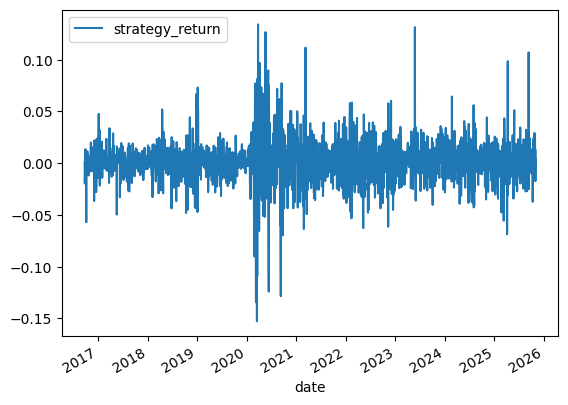

In [47]:
portfolio_df.plot()

In [48]:
spy_ret = data_scraper.get_sp500_data(tickers=['SPY'],
                                     start_date='2015-04-01',
                                     end_date='2025-11-01')
spy_ret = spy_ret.reset_index().drop('ticker', axis=1)
spy_ret['spy_ret'] = spy_ret['adj_close'].pct_change()
spy_ret = spy_ret[['date', 'spy_ret']]
spy_ret = spy_ret.set_index('date').dropna()
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:131: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Filtering data between 2015-04-01 and 2025-11-01
Filtering data for specified tickers


In [49]:
portfolio_df.to_csv('data/portfolio_returns.csv')

In [50]:
portfolio_df

,strategy_return,spy_ret
date,,
2016-09-22,0.001253,0.006302
2016-09-23,-0.019550,-0.005479
2016-09-26,-0.008414,-0.008102
2016-09-27,-0.010256,0.006208
2016-09-28,0.013572,0.004964
...,...,...
2025-10-27,0.022468,0.011798
2025-10-28,-0.002971,0.002656
2025-10-29,0.013471,0.000480


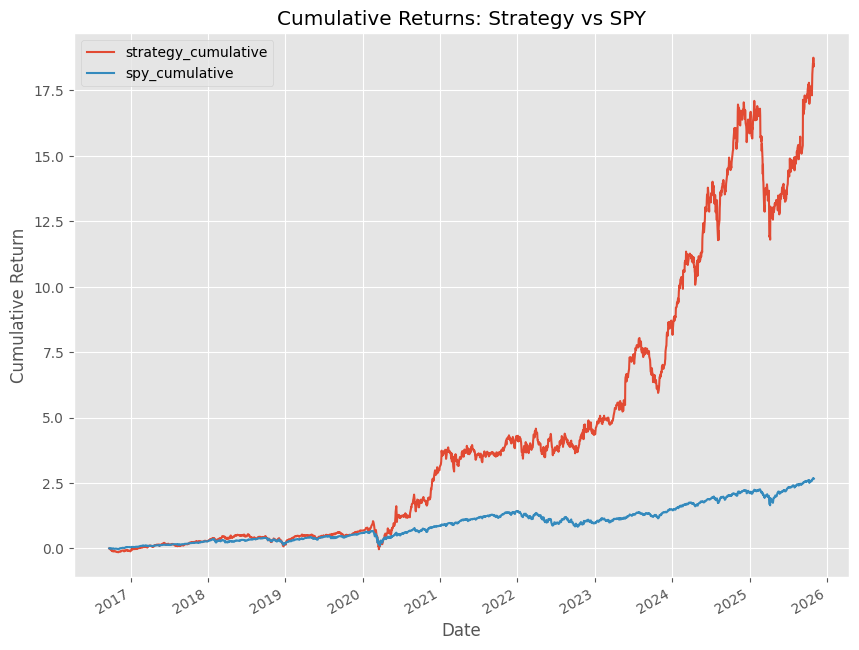

In [51]:
# Ensure portfolio_df has both simple-return columns
# 'strategy_return' should already exist; 'spy_ret' should have been merged earlier

# Sort and align
portfolio_df = portfolio_df.sort_index()

# Keep only rows where we have both returns (or choose fillna policy)
cum_input = portfolio_df[['strategy_return', 'spy_ret']].dropna()

# Daily cumulative simple returns
strategy_cum = (1 + cum_input['strategy_return']).cumprod() - 1
spy_cum      = (1 + cum_input['spy_ret']).cumprod() - 1

cum_df = pd.concat([strategy_cum, spy_cum], axis=1)
cum_df.columns = ['strategy_cumulative', 'spy_cumulative']

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))
cum_df.plot(ax=ax)
ax.set_title("Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
plt.show()

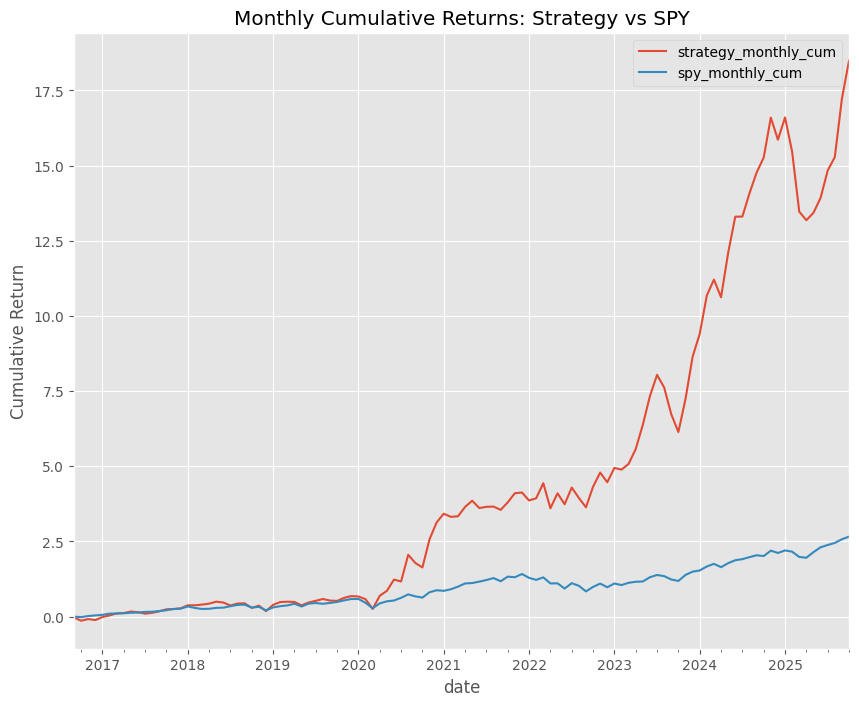

In [52]:
# Monthly simple returns from daily simple returns (product of (1+r) - 1)
monthly = (1 + cum_input['strategy_return']).resample('ME').apply(lambda x: x.prod()) - 1
monthly_spy = (1 + cum_input['spy_ret']).resample('ME').apply(lambda x: x.prod()) - 1

monthly_cum = (1 + monthly).cumprod() - 1
monthly_spy_cum = (1 + monthly_spy).cumprod() - 1

monthly_cum_df = pd.concat([monthly_cum, monthly_spy_cum], axis=1)
monthly_cum_df.columns = ['strategy_monthly_cum', 'spy_monthly_cum']

# Plot monthly cumulative
fig, ax = plt.subplots(figsize=(10, 8))
monthly_cum_df.plot(ax=ax)
ax.set_title("Monthly Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
plt.show()

In [53]:
# 1) Basic stats of daily strategy returns
print("Strategy return head / tail / describe:")
print(portfolio_df['strategy_return'].head())
print(portfolio_df['strategy_return'].tail())
print(portfolio_df['strategy_return'].describe())

# 2) Any extreme daily returns?
print("\nTop 10 largest strategy daily returns:")
print(portfolio_df['strategy_return'].nlargest(10))
print("\nTop 10 most negative strategy daily returns:")
print(portfolio_df['strategy_return'].nsmallest(10))

# 3) Check weight sums at each rebalance (if you still have `fixed_dates` & your stored `weights` per iteration, recompute)
# If you don't store weights history, recompute weights quickly from your optimisation loop's approach:
from collections import defaultdict
weight_sums = defaultdict(float)
# Recompute sums: iterate fixed_dates and reproduce weight calculation for that period (same as your loop)
for start_date in fixed_dates.keys():
    try:
        cols = fixed_dates[start_date]
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimisation_end_date   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date][cols]
        try:
            w = optimise_weights(prices=optimisation_df, lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
            w = pd.Series(w, index=optimisation_df.columns)
        except Exception:
            w = pd.Series(1/len(optimisation_df.columns), index=optimisation_df.columns)
        weight_sums[start_date] = w.sum()
    except Exception as e:
        weight_sums[start_date] = f"error: {e}"

ws = pd.Series(weight_sums)
print("\nWeight sums across rebalances (unique values / sample):")
print(ws.value_counts().head())
print(ws.head(10))

Strategy return head / tail / describe:
date
2016-09-22    0.001253
2016-09-23   -0.019550
2016-09-26   -0.008414
2016-09-27   -0.010256
2016-09-28    0.013572
Name: strategy_return, dtype: float64
date
2025-10-27    0.022468
2025-10-28   -0.002971
2025-10-29    0.013471
2025-10-30   -0.017200
2025-10-31    0.003925
Name: strategy_return, dtype: float64
count    2291.000000
mean        0.001503
std         0.020289
min        -0.152684
25%        -0.007503
50%         0.001416
75%         0.010713
max         0.134192
Name: strategy_return, dtype: float64

Top 10 largest strategy daily returns:
date
2020-03-24    0.134192
2023-05-25    0.131510
2020-05-18    0.126720
2021-03-09    0.111760
2025-09-10    0.107113
2025-04-09    0.098651
2020-04-06    0.096936
2020-06-08    0.089683
2020-06-05    0.087950
2020-03-19    0.081610
Name: strategy_return, dtype: float64

Top 10 most negative strategy daily returns:
date
2020-03-16   -0.152684
2020-03-09   -0.134446
2020-09-08   -0.128546
2020-

In [54]:
# cumulative portfolio value starting at 1.0
pv = (1 + portfolio_df['strategy_return']).cumprod()
final_return = pv.iloc[-1] - 1
print("Final cumulative return (total):", final_return)

Final cumulative return (total): 18.4866195009194


In [55]:
N = len(portfolio_df)
cagr = pv.iloc[-1] ** (252 / N) - 1
print("Geometric annualized return (CAGR):", cagr)

Geometric annualized return (CAGR): 0.3863260563351303


In [56]:
ann_vol = portfolio_df['strategy_return'].std() * (252 ** 0.5)
ann_return_geo = (1 + portfolio_df['strategy_return']).prod() ** (252 / N) - 1
sharpe = ann_return_geo / ann_vol
print("Ann vol:", ann_vol, "Ann geom return:", ann_return_geo, "Sharpe ≈", sharpe)

Ann vol: 0.32208095158876515 Ann geom return: 0.3863260563351303 Sharpe ≈ 1.1994688118917187


In [57]:
cum = (1 + portfolio_df['strategy_return']).cumprod()
rolling_max = cum.cummax()
drawdown = (cum - rolling_max) / rolling_max
print("Max drawdown:", drawdown.min())

Max drawdown: -0.5256778001187962


In [58]:
print("Duplicate rows:", portfolio_df.index.duplicated().sum())

Duplicate rows: 0


In [59]:
print("Top 10 pos/neg days:", portfolio_df['strategy_return'].nlargest(10), portfolio_df['strategy_return'].nsmallest(10))

Top 10 pos/neg days: date
2020-03-24    0.134192
2023-05-25    0.131510
2020-05-18    0.126720
2021-03-09    0.111760
2025-09-10    0.107113
2025-04-09    0.098651
2020-04-06    0.096936
2020-06-08    0.089683
2020-06-05    0.087950
2020-03-19    0.081610
Name: strategy_return, dtype: float64 date
2020-03-16   -0.152684
2020-03-09   -0.134446
2020-09-08   -0.128546
2020-03-12   -0.126464
2020-06-11   -0.124115
2020-03-18   -0.109316
2020-02-27   -0.090183
2020-09-23   -0.069764
2020-06-10   -0.069417
2025-04-04   -0.068637
Name: strategy_return, dtype: float64


In [60]:
new_df.tail()

ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,AMAT,...,WDAY,WDC,WFC,WMT,WYNN,XOM,YUM,PYPL,XYZ,TTD
date,,,,,,,,,,,,,,,,,,,,,
2025-10-27,268.549652,228.029999,127.180000,250.770004,357.799988,243.009995,280.529999,313.529999,79.309998,230.877441,...,238.910004,126.568230,86.554932,104.470001,125.180252,114.934715,142.306091,70.087975,80.150002,53.610001
2025-10-28,268.739471,227.539993,126.610001,253.350006,359.910004,239.350006,279.630005,311.079987,78.389999,227.194656,...,236.929993,124.819633,86.445503,103.169998,120.599754,114.032600,140.425003,72.851585,80.180000,51.669998
2025-10-29,269.438812,225.139999,124.430000,247.750000,337.859985,235.039993,261.220001,297.079987,77.980003,235.288788,...,231.360001,141.266418,85.550209,102.459999,120.619713,115.440285,138.533966,69.519287,76.510002,49.959999
2025-10-30,271.137146,228.199997,124.669998,249.250000,339.239990,232.899994,261.529999,300.769989,78.190002,232.095062,...,232.869995,138.019028,85.540260,102.230003,119.521988,113.695557,138.404572,67.773323,73.919998,48.970001
2025-10-31,270.108154,218.039993,123.620003,250.100006,340.309998,234.130005,260.299988,301.339996,78.959999,232.643982,...,239.919998,150.089325,86.515137,101.180000,118.743599,113.368416,137.558594,69.110229,75.940002,50.279999


In [61]:
max_date = new_df.index.max()

In [62]:
max_date

Timestamp('2025-10-31 00:00:00')

In [73]:
portfolio_size = 500
new_portfolio = weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True)
new_portfolio['allocation'] = new_portfolio['weight'] * portfolio_size
new_portfolio['shares'] = (new_portfolio['allocation'] / new_df.loc[max_date, new_portfolio.index]).astype(int)
new_portfolio['shares_cost'] = new_portfolio['shares'] * new_df.loc[max_date, new_portfolio.index] 
new_portfolio

,weight,allocation,shares,shares_cost
NVDA,0.05000,25.00,0,0.000000
LRCX,0.55002,275.01,1,157.201202
CMCSA,0.05000,25.00,0,0.000000
ORCL,0.05000,25.00,0,0.000000
MU,0.05000,25.00,0,0.000000
FSLR,0.05000,25.00,0,0.000000
TTD,0.05000,25.00,0,0.000000
INTC,0.05000,25.00,0,0.000000
CCL,0.05000,25.00,0,0.000000
AMD,0.05000,25.00,0,0.000000


In [82]:
dates = sorted(model_df['date'].unique())
x=0
for d in dates:
    # Train on data strictly before the prediction date `d` to avoid lookahead.
    train_start = (pd.to_datetime(d) - pd.DateOffset(months=12)).normalize()
    # Exclude rows dated == d so targets corresponding to future outcomes are not leaked into training
    train_end = (pd.to_datetime(d) - pd.DateOffset(days=1)).normalize()
    
    print(f"Training from {train_start.date()} to {train_end.date()} for prediction date {d}")
    train = model_df[(model_df['date'] >= train_start) & (model_df['date'] <= train_end)]
    print(train.tail())
    x += 1
    if x > 20:
        break

Training from 2015-02-28 to 2016-02-28 for prediction date 2016-02-29 00:00:00
Empty DataFrame
Columns: [date, ticker, garman_klass_volatility, rsi, bb_low, bb_mid, bb_high, bb_pct, macd, close_over_open, return_1m, return_2m, return_3m, return_6m, return_9m, return_12m, mkt_rf, smb, hml, rmw, cma, target_1m]
Index: []

[0 rows x 22 columns]
Training from 2015-03-31 to 2016-03-30 for prediction date 2016-03-31 00:00:00
          date ticker  garman_klass_volatility        rsi    bb_low    bb_mid  \
122 2016-02-29    WFC                 6.161993  42.899113  3.574261  3.616450   
123 2016-02-29    WMT                 3.859567  55.543706  2.941114  2.967386   
124 2016-02-29   WYNN                 7.928214  68.328362  3.876347  4.140402   
125 2016-02-29    XOM                 8.041867  52.726163  3.917073  3.973798   
126 2016-02-29    YUM                 6.338964  55.225011  3.698915  3.765098   

      bb_high     bb_pct      macd  close_over_open  ...  return_3m  \
122  3.658639   8.8

In [85]:
fixed_dates
dict_items = {}
for _, item in fixed_dates.items():
  for stock in item:
    if stock not in dict_items:
      dict_items[stock] = 0
    dict_items[stock] += 1
  
    

In [89]:
items_dataframe = {}
for k, v in dict_items.items():
  items_dataframe[k] = [v]

In [100]:
past_stocks = pd.DataFrame(items_dataframe).T

In [102]:
past_stocks = past_stocks.sort_values(by=0, ascending=False)

In [104]:
past_stocks.head(20)

,0
TSLA,61
F,39
NVDA,38
CCL,37
FCX,36
AMD,33
NFLX,32
CMG,29
PSKY,27
WYNN,25


In [105]:
selected

,date,ticker,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,bb_pct,macd,close_over_open,...,return_3m,return_6m,return_9m,return_12m,mkt_rf,smb,hml,rmw,cma,y_pred
16448,2025-10-31,NVDA,11.518860,64.206997,5.153538,5.242347,5.331156,37.623681,2.823975,-0.019423,...,0.044179,0.108898,0.059813,0.035830,2.599456,-0.679734,-1.226280,1.517400,1.342551,0.057238
16395,2025-10-31,LRCX,10.523843,66.517125,4.879789,4.990862,5.101935,30.497808,6.357859,-0.033459,...,0.165090,0.127077,0.077474,0.065464,2.022899,-1.366466,0.323548,-1.635127,-0.497471,0.049916
16352,2025-10-31,CMCSA,4.309131,31.560782,3.358448,3.417043,3.475638,7.147395,-1.964225,0.040687,...,-0.053963,-0.030535,-0.017744,-0.033840,0.538235,0.171947,0.462817,0.641017,1.378787,0.047109
16411,2025-10-31,ORCL,12.514514,44.426904,5.556976,5.657116,5.757255,45.421180,-2.181548,0.011875,...,0.012064,0.110295,0.050332,0.038866,2.200013,-1.022044,-1.087015,-0.269956,0.854025,0.046734
16405,2025-10-31,MU,11.947083,71.387424,5.179637,5.319100,5.458562,41.069150,7.417860,-0.017630,...,0.209629,0.154080,0.098575,0.070109,2.875900,-1.759886,1.096340,-0.235547,1.736989,0.044596
16374,2025-10-31,FSLR,12.342645,66.744521,5.376269,5.461426,5.546584,47.877341,2.138467,0.069049,...,0.151725,0.256157,0.212027,0.171489,5.002094,-4.940300,-2.995773,-5.670452,7.484922,0.044438
16458,2025-10-31,TTD,6.129550,45.515004,3.906560,3.970803,4.035045,11.662427,-0.119479,0.024156,...,-0.166910,-0.010693,-0.091013,-0.069109,2.235441,1.203438,-3.816482,2.199879,0.318210,0.043545
16384,2025-10-31,INTC,5.532612,65.733380,3.582039,3.664476,3.746912,9.912885,2.946953,-0.017107,...,0.191958,0.092348,0.074683,0.052994,2.044980,-0.921620,2.693616,-1.513326,0.203209,0.039601
16350,2025-10-31,CCL,4.455279,47.546595,3.348180,3.393010,3.437841,7.496880,-0.371711,0.020323,...,-0.010638,0.078303,0.004574,0.022787,2.310311,0.293791,-1.193711,-1.460186,2.604126,0.037019
16334,2025-10-31,AMD,12.518089,68.565455,5.319308,5.467374,5.615441,45.845155,7.448836,-0.013496,...,0.132545,0.174946,0.092047,0.049114,1.687437,0.043418,-1.318438,-0.835249,1.169694,0.036547
